By Akinde Kadjo

**Goal:** The goal of this project is to distinguish normal electrocardiogram (ECG) heartbeat signals from abnormal ones. The Dataset was obtained from [Kaggle](https://www.kaggle.com/datasets/shayanfazeli/heartbeat/data). Its original source is [The PTB Diagnostic ECG Database](https://www.physionet.org/content/ptbdb/1.0.0/).

# Imports

In [16]:
#Importing all of the libraries that may be needed for the project
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import set_config
set_config(display='diagram')

from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             accuracy_score, precision_score, recall_score, 
                             balanced_accuracy_score,classification_report,
                             ConfusionMatrixDisplay,roc_auc_score,
                             PrecisionRecallDisplay, RocCurveDisplay,f1_score)

from xgboost import  XGBClassifier

from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import random

import lazypredict
from lazypredict.Supervised import LazyClassifier

from tqdm import tqdm
from tqdm.keras import TqdmCallback
import time

import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [2]:
#Loading the data
normal_df = pd.read_csv('ptbdb_normal.csv', header=None)
print(f'normal data shape: {normal_df.shape}')
abnormal_df = pd.read_csv('ptbdb_abnormal.csv', header=None)
print(f'abnormal data shape: {abnormal_df.shape}')

normal data shape: (4046, 188)
abnormal data shape: (10506, 188)


In [3]:
normal_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.00,0.90,0.36,0.05,0.05,0.13,0.13,0.12,0.11,0.11,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1.00,0.79,0.38,0.12,0.00,0.17,0.28,0.29,0.33,0.35,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [4]:
abnormal_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.93,0.87,0.89,0.93,0.91,0.93,0.80,0.75,0.69,0.64,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
1,1.00,0.61,0.38,0.25,0.22,0.28,0.25,0.18,0.15,0.12,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00


# Functions

In order to keep a clean notebook, I'm storing all of the functions that I've created in this section. These functions pertain to data extraction, data cleaning, plots, prediction models and regression outputs.

In [5]:
##Creating a function for plotting multiple ECG
def multi_plot(plot_df):
    y_len = len(plot_df)
    fig, axes = plt.subplots(1,y_len, figsize = (30, 6),constrained_layout=True)
    axes = axes.ravel()
    for i in range(y_len):
        axes[i].plot(plot_df.iloc[i])
        axes[i].set_title(f'ECG #{i}')
    return plt.show()

# Visualization

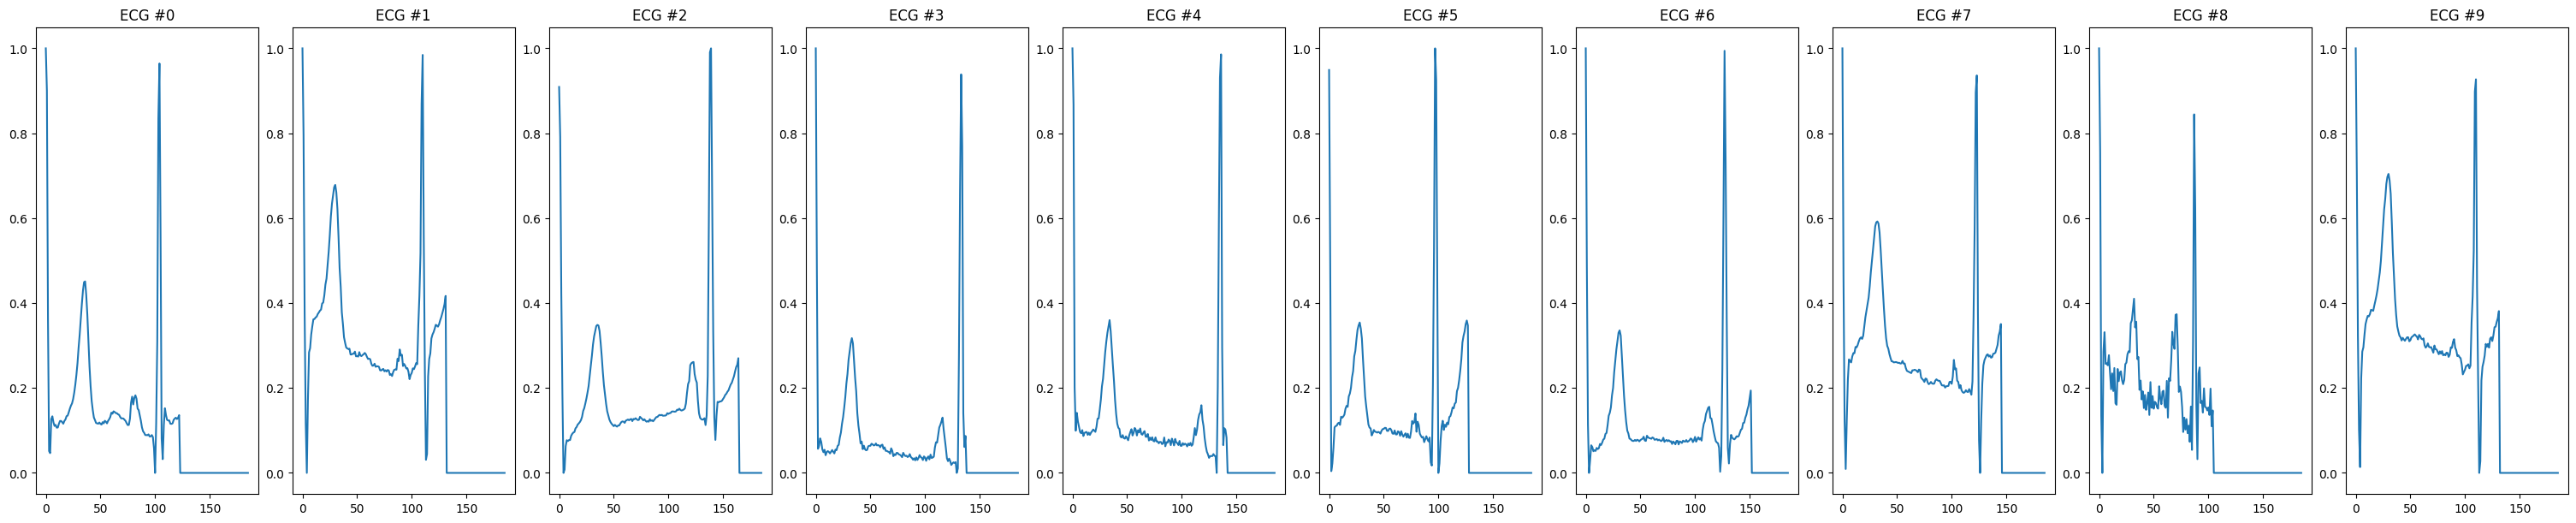

In [6]:
multi_plot(normal_df.iloc[0:10,0:186])

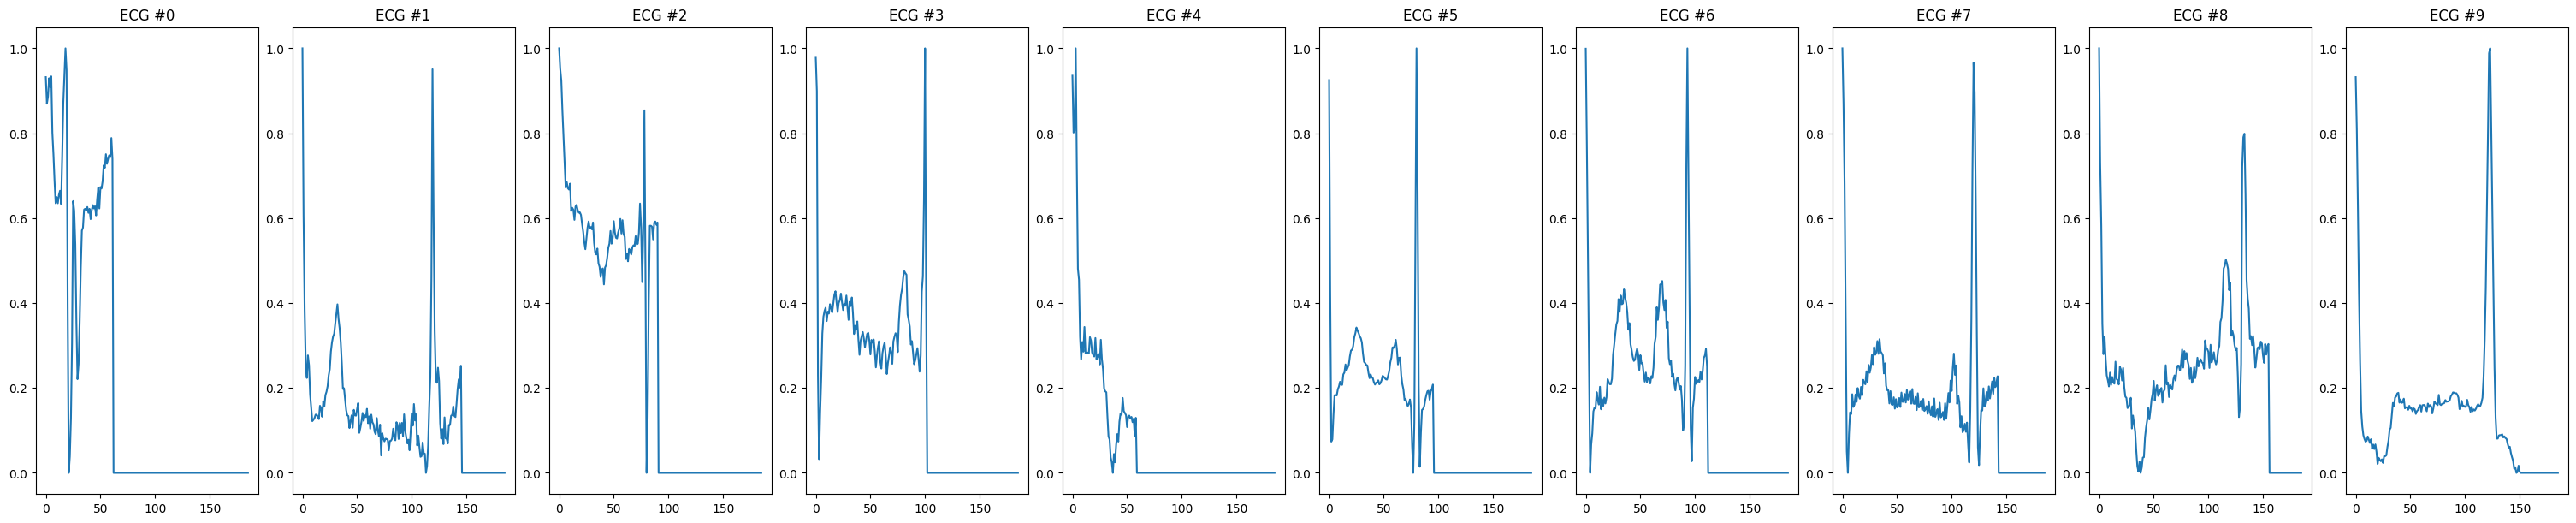

In [7]:
multi_plot(abnormal_df.iloc[0:10,0:186])

# Data Cleaning

The dataset is already normalized, cut and padded. So very little cleaning is needed.

In [10]:
X = np.concatenate((normal_df.iloc[:,0:186],abnormal_df.iloc[:,0:186]))
print(f'X shape: {X.shape}')
y = np.concatenate((np.zeros(len(normal_df)), np.ones(len(abnormal_df)) ))
print(f'y shape: {y.shape}')

X shape: (14552, 186)
y shape: (14552,)


In [11]:
#Performing a train test split, here the random state of 42 is chosen for consistency
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,test_size = 0.20)

# Traditional Machine Learning

I'll use LazyClassifier to have a quick idea of what model would work best.

In [12]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models.head()

100%|██████████| 29/29 [02:11<00:00,  4.54s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.98,0.97,0.97,0.98,5.20
ExtraTreesClassifier,0.98,0.97,0.97,0.98,2.11
LGBMClassifier,0.97,0.97,0.97,0.97,0.90
RandomForestClassifier,0.97,0.96,0.96,0.97,7.95
BaggingClassifier,0.95,0.94,0.94,0.95,12.20


XGBClassifier gives at least 97% accuracy, let's see if Dynamic time warping (DTW) improves the accuracy

# Dynamic time warping (DTW)

# Conclusion